#### Helper Methods

In [1]:
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt

In [399]:
log = True
component_path = "./sector_components/"
pricing_path = "./pricing/"
date_fmt = '%m-%d-%Y'

#variables for data download
frame = 60 #for limiting the range of optimizations, 1 year
hist_window = frame * 5 #for historical pricing 3 years
start_date = datetime.now() - timedelta(hist_window)
start_date = start_date.strftime(date_fmt)
sleep_time = 5

#variables for performance analysis
frequency = "W-FRI"
days, lb, we = 20, 5, 0.15 #ATTENTION this will drive the recomendations (re-run to check key vars)
min_gross=1; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy_sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark_etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [363]:
short_float = lambda x: '%.3f' % x
def compound(df):
    pct = df.pct_change() + 1
    pct.iloc[0] = 1
    return pct.cumprod()
def show_weights(weights, labels, ret, sigma):
    df = pd.DataFrame(weights, columns=labels)
    df['return'] = ret * 252
    df['sigma'] = sigma * np.sqrt(252)
    df['sharpe'] = df['return'] / df['sigma']
    return df

In [364]:
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values    
def get_weights(px, freq, lb, min_sum, max_sum, min_w, max_w):
    px = clean_nas(px)
    returns = px.sort_index().pct_change(); returns.iloc[0] = 0
    intervals = pd.to_datetime(date_intervals(returns, freq).index.tolist())
    valid_dates = [d for d in intervals if d in returns.index]    
    hist_alloc = pd.DataFrame(np.zeros((returns.shape)), index=returns.index, columns=returns.columns)
    for i in valid_dates:
        lb_returns = returns.loc[:i.date()].tail(lb).dropna()
        weights = np.array([0 for _ in range(len(returns.columns))])
        if (len(lb_returns) > 2):
            n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_returns)
            weights = get_mvo_allocations(
                n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w)
        hist_alloc.loc[i.date()] = weights
    hist_alloc = hist_alloc.loc[returns.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.replace(np.nan, 0, inplace=True)
    return returns, hist_alloc
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w):
    mu = mu_ret.T
    Sigma = cov_mtrx
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    # removed the min_sum
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(cvx.abs(w)) <= max_sum,
         w > min_w,
         w < max_w])
    gamma.value = 50; prob.solve()
    if prob.status == 'optimal': 
        return [i[0] for i in w.value.tolist()]
def recommend_allocs(px, frame, lb, freq, min_sum, max_sum, min_w, max_w):
    px = clean_nas(px)
    px_portion = px[-abs(frame):].copy() 
    returns, alloc = get_weights(
        px_portion, frequency, lb, min_sum, max_sum, min_w, max_w)
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["M2-cvxopt"])
    return px_portion, returns, alloc, pdf


In [365]:
p_template = "{0} Return: {1:.2f}%, StdDev: {2:.2f}%, Sharpe: {3:.2f}"
def calc_port_performance(arr, weights):
    return np.cumprod(np.sum(arr * weights, axis=1) + 1)
def date_rules(date_range, tgt_date_str, freq):
    #return a list of dates
    tgt_dt = datetime.strptime(tgt_date_str, date_fmt)
    return date_range[:date_range.index(tgt_dt)+1][::-freq]
def date_intervals(df, freq):
    #using pandas
    return df.resample(freq, closed='left', label='left').mean()
# portfolio metrics: is this right? Need to be adjusted by len
def portfolio_metrics(name, pdf):
    timespan = len(pdf)
    ret = (pdf.pct_change().mean() * timespan).values[0]
    std = (pdf.pct_change().std() * sqrt(timespan)).values[0]
    if log: print(p_template.format(name, ret * 100, std * 100, ret / std))
    return ret, std, ret / std

In [366]:
cleanmin = lambda x: max(float(x), 1)
def clean_nas(df):
    cols = df.count().sort_values()[df.count().sort_values() < 1].index.tolist()
    df = df.drop(cols, axis=1)
    df.fillna(method='pad', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df = df.applymap(cleanmin)
    return df
def period_allocs(w, irange):
    w = (recomend_allocs(w, irange) / max_w).astype(np.int)
    return w
# 1) get sectors 2) find stocks in sector pricing 3) merge all dfs into one 4) plot all as index
def plot_recomendations(picks, lb):
    sel_sectors = pd.unique(picks['Sector']) #1
    consol_px = pd.DataFrame([])
    idx_range = px_spy[-lb:].index
    for s in sel_sectors:
        s_px = load_pricing(s + '-hold-pricing.csv', 'Date').loc[idx_range].sort_index()
        s_px = clean_nas(s_px)
        s_tickers = top_picks[top_picks['Sector'] == s].index.tolist()
        s_df = s_px[s_tickers] #2
        consol_px = consol_px.merge(s_df, left_index=True, right_index=True, how='outer') #3
    compound(consol_px).plot() #4 plot compound
    print("From:", consol_px.index[0], "to: ", consol_px.index[-1])
    return consol_px

In [367]:
#Download / load utility methods
#Downloads pricing on all components for each ETF
def get_pricing(fname, ticker_list, start_date):
    if log: print("Getting pricing for:", fname, start_date)
    px = web.DataReader(ticker_list,data_source='yahoo',start=start_date)['Adj Close']
    px.sort_index(ascending=True, inplace=True)
    px.to_csv(pricing_path + fname)
    return px
# Load pricing from hard drive
def load_pricing(f, idx_col):
    fname = pricing_path + f
    px = pd.read_csv(fname, index_col=idx_col, parse_dates=True)
    px.sort_index(ascending=True, inplace=True)
    if log: print("Loaded pricing for {}, with shape {}".format(f, px.shape))
    return px
# Load component from ETF holding CSVs
col_names = ['Symbol','Company', 'Weight']
def load_components(cos, pattern, cols, idxcol, sectors, srows=1):
    flist = os.listdir(component_path)
    files = [f for f in flist if f.startswith(pattern)]
    for s in sectors:
        fname = component_path + pattern + s.lower() + '.csv'
        df = pd.read_csv(fname, skiprows=srows, index_col=idxcol, usecols=cols)
        df.index.name = col_names[0]
        df.columns = col_names[1:]
        df = clean_idx(df, ' ')
        df['ETF'] = s
        sector_tickers_map[s] = df.index.tolist()
        cos = cos.append(df)
    return cos
# Exception safe downloader
def get_safe_pricing(fname, ticker_list, s_date):
    while True:
        try:
            get_pricing(fname, ticker_list, s_date); break
        except Exception as err:
            print("Error: {0}, waiting to try again in {1}".format(err, sleep_time))
            sleep(sleep_time)
#For each ETF downloads 
def refresh_components(etfs):
    while len(etfs) > 0: 
        val = etfs[-1]; 
        tickers = sector_tickers_map[val] # for individual components
        get_safe_pricing(val + '-hold-pricing.csv', tickers, start_date)
        etfs.pop()

In [368]:
def clean_load(pattern, idxcol, cols, col_names, s, srows=0):
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=srows, index_col=idxcol, usecols=cols)
    df.index.name = col_names[0]
    df.columns = col_names[1:]
    return df
def clean_idx(df, s):
    dfidx = df.index.dropna()
    df = df.loc[dfidx].copy()
    rows = df[df.index.str.contains(s) == True]
    if len(rows) > 0:
        idx = df[df.index.str.contains(s) == True].index
        df = df.drop(idx, axis=0)
    return df

#### Load sector components from hard-drive

In [369]:
sector_tickers_map = {}
companies = pd.DataFrame([])

# load spy sector components
companies = load_components(
    companies, r'holdings-spy-', ['Symbol','Company Name', 'Index Weight'], 
    'Symbol', ticker_map['spy_sectors'], srows=1)
print("Companies loaded:", companies.shape)

# load ark ETF components
companies = load_components(
    companies, r'holdings-ark-', ['ticker','company', 'weight(%)'], 
    'ticker', ticker_map['ark_etfs'], srows=0)
print("Companies loaded:", companies.shape)

px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
px_ark_etfs = load_pricing('ark-etfs.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

# load ark etfs components

Companies loaded: (505, 3)
Companies loaded: (684, 3)
Loaded pricing for spy-sectors.csv, with shape (870, 10)
Loaded pricing for ark-etfs.csv, with shape (843, 4)
Loaded pricing for SPY.csv, with shape (870, 1)


#### Get Data from the Server

In [ ]:
#logic for appending prices instead of download over and over again
dr = pd.date_range(end='2-1-18', periods=10)
np.random.seed(42)
series = np.random.random(50).reshape(10, 5)
dra, drb = dr[:7], dr[-7:]
sa, sb = series[:7], series[-7:]
cols = ['A', 'B', 'C', 'D', 'E']
dfa, dfb = pd.DataFrame(sa, index=dra, columns=cols), pd.DataFrame(sb, index=drb, columns=cols)
dfb.combine_first(dfa)
#dfa, dfb

In [298]:
spyder_etfs = [e for e in ticker_map['spy_sectors']]
ark_etfs = [e for e in ticker_map['ark_etfs']]
refresh_components(spyder_etfs)
refresh_components(ark_etfs)

Getting pricing for: ARKW-hold-pricing.csv 08-23-2014
Getting pricing for: ARKQ-hold-pricing.csv 08-23-2014


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'TSLA', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'SSYS', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'AMZN', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'BIDU', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'NVDA', replacing with NaN.
  warnings.warn(ms

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'WMT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'IFNNY', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'GBTC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'NNDM', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'BCG', replacing with NaN.
  warnings.warn(msg

Error: No data fetched using 'YahooDailyReader', waiting to try again in 5
Getting pricing for: ARKQ-hold-pricing.csv 08-23-2014
Getting pricing for: ARKK-hold-pricing.csv 08-23-2014
Getting pricing for: ARKG-hold-pricing.csv 08-23-2014


In [ ]:
get_safe_pricing('spy-sectors.csv', ticker_map['spy_sectors'], start_date)
get_safe_pricing('ark-etfs.csv', ticker_map['ark_etfs'], start_date)
get_safe_pricing('SPY.csv', ['SPY'], start_date)

px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
px_ark_etfs = load_pricing('ark-etfs.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

#### Generate Trading Recomendations

TODO List
1. Produce ETF level recomendation (sector weightings) DONE
2. Produce recomendations for each sector DONE
3. Calculate sharpe rankings for a given company list DONE
4. Show spread returns starting at different times for each sector
5. Create long / short optimizers
6. Test portofolio with both long and shorts

In [372]:
log = False
sum_cols = ["Alloc", "Ret", "Std", "Sharpe", "Sector"]
summary = pd.DataFrame([], columns=sum_cols)
max_w=we; top = int(1/max_w); 

In [373]:
#Produce best recomendations by sector
#Another way to do this is to put all sector together and let the algo pick the best 20 positios
for dwld_key in ticker_map['spy_sectors']:
    if log: print("Running optimization for:", dwld_key)
    # Load pricing for ETF and all its components
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
    spyder_etf = px_spy_etfs[dwld_key].copy()
    # Run optimization for ETF Components
    px_portion, returns, alloc, pdf = recommend_allocs(
        px, frame, lb, frequency, min_gross, max_gross, min_w, we)
    portfolio_metrics('M2', pdf);
    # Show portfolio metrics for ETF
    if log: print("Benchmark")
    portfolio_metrics(dwld_key, pd.DataFrame(spyder_etf, index=spyder_etf.index, columns=[dwld_key]));
    # List recomended positions per sector
    r = returns[-lb:].astype(np.float16); w = alloc[-lb:].astype(np.float16)
    # Note: Need to get certainty that the optimization is done as of last pricing
    rec = selected_allocs(alloc, frame, frequency, 1)[:top]
    tickers = rec.index.tolist()
    if len(tickers) > 0:
        sel_df = px[tickers][-lb:].pct_change()
        sel_df_ret = sel_df.mean() * (lb); sel_df_std = sel_df.std() * sqrt(lb)
        sel_df_sharpe = sel_df_ret / sel_df_std
        vals = np.array(
            [rec.values, sel_df_ret.values, sel_df_std.values, 
             sel_df_sharpe.values, [dwld_key] * len(tickers)])
        sector_df = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
        summary = summary.append(sector_df)

summary = summary.astype({"Alloc": np.float, "Ret": np.float, "Std": np.float, "Sharpe": np.float}, copy=True)
summary['Spread'] = summary['Ret'] - summary['Std']

In [374]:
sum_gb = summary.groupby(by="Sector").mean()
cols_to_rank = ['Ret', 'Sharpe', 'Spread']
ranked_sectors = sum_gb[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
if log: 
    print("Mean recomendations grouped by by Sector")
    print(sum_gb.sort_values(by="Spread", ascending=False).applymap(short_float))
if log: 
    print("Sectors ranked from best to worst")
    print(ranked_sectors)

In [375]:
ranked_cos = summary[cols_to_rank].rank(ascending=False).mean(axis=1).sort_values(ascending=True)
top_picks = summary.loc[ranked_cos[:top].index]
if log: print("\nPortfolio Sector Allocations")
print(top_picks.groupby(by='Sector')['Alloc'].count() / len(top_picks))
if log: print("Top 20 companies ranked from best to worst\n")
top_picks

Sector
XLF     0.125
XLK     0.375
XLRE    0.125
XLV     0.125
XLY     0.250
Name: Alloc, dtype: float64


,Alloc,Ret,Std,Sharpe,Sector,Spread
NWL,0.119995,0.124576,0.020722,6.011754,XLY,0.103854
QRVO,0.083618,0.227883,0.183464,1.242108,XLK,0.044418
FFIV,0.119995,0.046858,0.030752,1.523754,XLK,0.016106
XL,0.119995,0.055760,0.043116,1.293254,XLF,0.012644
DRE,0.119995,0.047870,0.038901,1.230544,XLRE,0.008969
TWX,0.119995,0.029659,0.020673,1.434649,XLY,0.008986
MSI,0.119995,0.059185,0.054748,1.081037,XLK,0.004437
EW,0.119995,0.048540,0.042721,1.136204,XLV,0.005819


From: 2018-01-22 00:00:00 to:  2018-02-02 00:00:00


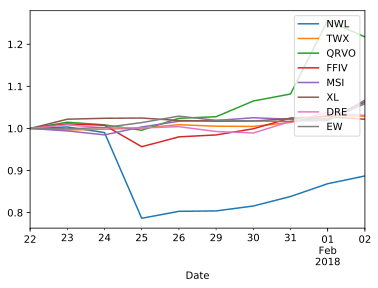

In [383]:
consol_tp_px = plot_recomendations(top_picks, lb*2)

Market wide approach

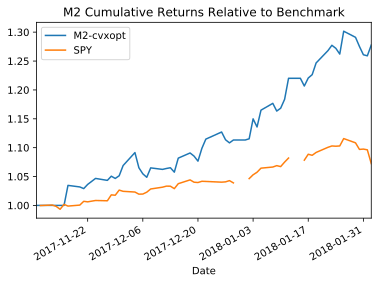

In [377]:
#Produce best recomendations looking at all companies in SPY
summary = pd.DataFrame([], columns=sum_cols)
consol_px = pd.DataFrame([])

for dwld_key in ticker_map['spy_sectors']:
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')[frame:].copy()
    consol_px = consol_px.merge(px, left_index=True, right_index=True, how='outer')

# Run optimization for all members of the SPY
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, frame, lb, frequency, min_gross, max_gross, min_w, we)
portfolio_metrics('M2', pdf);
portfolio_metrics('SPY', px_spy[frame:]);

# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_spy = (px_spy[-len(pdf):].pct_change() + 1).cumprod()
s_spy.plot(ax=ax, legend='right');

In [379]:
# List recomended positions per sector
r = returns[-lb:].astype(np.float16); w = alloc[-lb:].astype(np.float16)
# selected top picks
rec = selected_allocs(alloc, frame, frequency, 1)[:top]
tickers = rec.index.tolist()
# calculated key metrics for each stock
sel_df = px_portion[tickers][-lookback:].pct_change()
sel_df_ret = sel_df.mean() * (252/lookback); sel_df_std = sel_df.std() * sqrt(lookback)
sel_df_sharpe = sel_df_ret / sel_df_std
vals = np.array([
    rec.values, sel_df_ret.values, sel_df_std.values, 
    sel_df_sharpe.values, companies.loc[tickers]['ETF'].tolist()])
summary = pd.DataFrame(vals.T, index=tickers, columns=sum_cols)
summary = summary.astype({"Alloc": np.float, "Ret": np.float, "Std": np.float, "Sharpe": np.float}, copy=True)
summary['Spread'] = summary['Ret'] - summary['Std']
print(summary.groupby(by='Sector')['Alloc'].count() / len(top_picks))
summary

Sector
XLF    0.125
XLI    0.125
XLK    0.375
XLP    0.125
XLY    0.250
Name: Alloc, dtype: float64


,Alloc,Ret,Std,Sharpe,Sector,Spread
XL,0.119995,0.070352,0.057355,1.226602,XLF,0.012997
HRS,0.119995,0.043556,0.078468,0.555084,XLI,-0.034911
MSI,0.119995,0.076088,0.066028,1.152352,XLK,0.010060
EA,0.119995,0.065749,0.091575,0.717983,XLK,-0.025826
NWL,0.119995,-0.072662,0.228296,-0.318280,XLY,-0.300958
QRVO,0.119995,0.116571,0.190881,0.610699,XLK,-0.074310
MAT,0.113831,0.037546,0.166812,0.225078,XLY,-0.129266
DPS,0.107422,0.157804,0.230964,0.683238,XLP,-0.073161


From: 2018-01-22 00:00:00 to:  2018-02-02 00:00:00


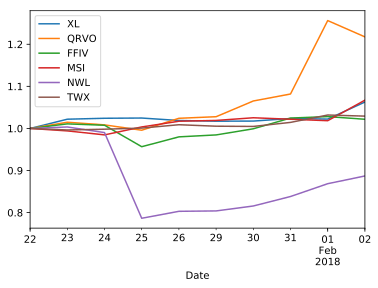

In [384]:
plot_recomendations(summary, lb*2);

In [386]:
#NEED TO DEFINE A REUSABLE FUNCTION FOR THIS

#Which one of the two approaches to pick?
px_a = consol_px[top_picks.index][-lookback:]
px_b = consol_px[summary.index][-lookback:]
mu_a, mu_b = px_a.pct_change()[1:].mean().mean() * (252/lb), px_b.pct_change()[1:].mean().mean() * (252/lb)
std_a, std_b = px_a.pct_change()[1:].std().mean() * sqrt(lb), px_b.pct_change()[1:].std().mean() * sqrt(lb)
sr_a, sr_b = mu_a / std_a, mu_b / std_b
print("Ann. Ret A:", short_float(mu_a), "Ann. Ret B:", short_float(mu_b))
print("Std Dev A:", short_float(std_a), "Std Dev B:", short_float(std_b))
print("Sharpe A:", short_float(sr_a), "Sharpe B:", short_float(sr_b))

#px_a_idx = compound(px_a); px_a_idx.plot()
round_shares = lambda x: round(x, 0)
port_bal = 200000; alloc = 1 / len(px_a)
shares = (port_bal * alloc) / px_b[-1:]
shares.apply(round_shares)

Ann. Ret A: 0.176 Ann. Ret B: 0.261
Std Dev A: 0.048 Std Dev B: 0.071
Sharpe A: 3.667 Sharpe B: 3.664


,XL,HRS,MSI,EA,NWL,QRVO,MAT,DPS
Date,,,,,,,,
2018-02-02,261.0,64.0,96.0,80.0,357.0,124.0,605.0,84.0


#### Run Optimizations

M2 Return: 22.19%, StdDev: 5.29%, Sharpe: 4.19
SPY Return: 25.24%, StdDev: 7.95%, Sharpe: 3.18


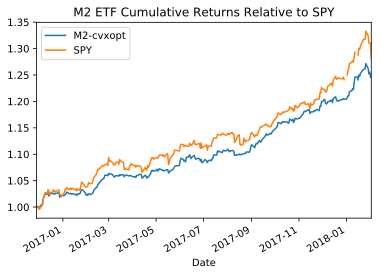

In [391]:
#Produce ETF level recomendation (sector weightings)
log = True
etfs_px_portion, etfs_ret, etfs_alloc, etfs_pdf = recommend_allocs(
    px_spy_etfs, hist_window, lb, frequency, min_gross, max_gross, min_w, we)
portfolio_metrics('M2', etfs_pdf)

s_spy = (px_spy[-len(etfs_px_portion):].pct_change() + 1).cumprod()
portfolio_metrics('SPY', s_spy)
# Plot optimization vs. benchmark
ax = etfs_pdf.plot(title="M2 ETF Cumulative Returns Relative to SPY");
s_spy.plot(ax=ax, legend='right');

In [392]:
#Produce optimization for a given sector group
def run_sector_opt(group, dwld_key, frame, lback, w):
    px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date') #this is inneficient, fix
    px_spy_etfs = load_pricing(group, 'Date') #this is inneficient, fix
    spyder_etf = px_spy_etfs[dwld_key].copy()
    # Run a sector specific optimization
    px_portion, returns, alloc, pdf = recommend_allocs(px, frame, lback, frequency, min_gross, max_gross, min_w, w)
    benchmark = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
    if log == True: 
        portfolio_metrics('M2', pdf);
        portfolio_metrics(dwld_key, pd.DataFrame(benchmark));
    return px_portion, returns, alloc, pdf, benchmark

def plot_two_series(tsa, tsb, label1, label2, xlabel, ylabel, title):
    plt.plot(tsa, "b-", label=label1)
    plt.plot(tsb, "g-", label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)

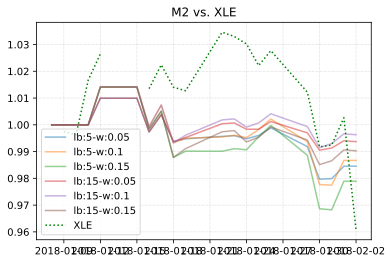

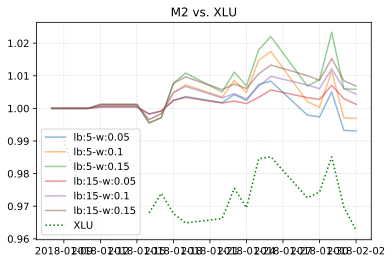

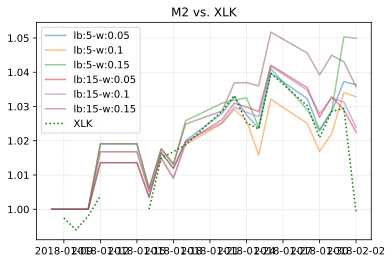

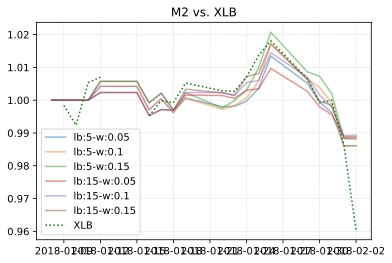

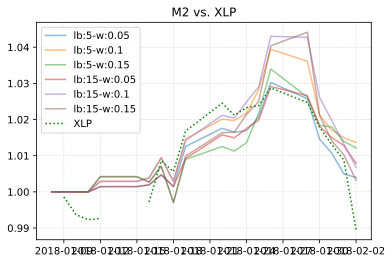

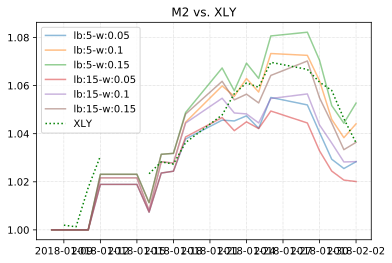

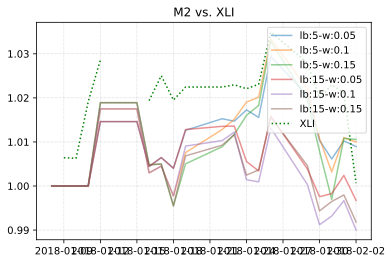

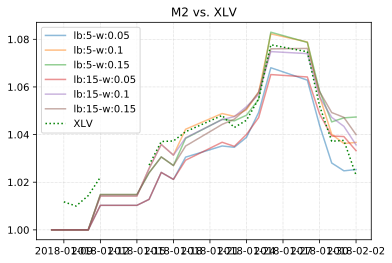

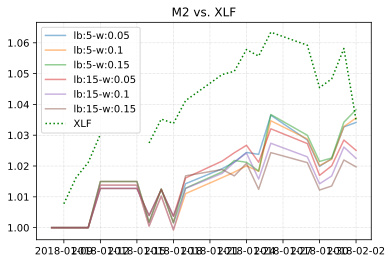

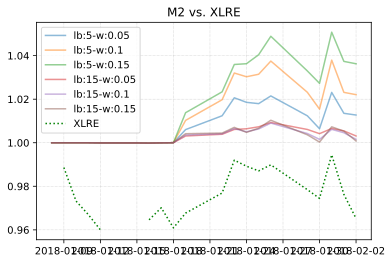

In [401]:
# All sectors
spys, arks = ticker_map['spy_sectors'], ticker_map['ark_etfs']
spyf, arkf = 'spy-sectors.csv', 'ark-etfs.csv'
log = False
for s in spys:
    dwld_key = s
    check_sector_vars(spyf, s, days)
    #px_portion, returns, alloc, pdf, benchmark = run_sector_opt(spyf, dwld_key, hist_window, lb, we)
    #plot_two_series(pdf, benchmark, "M2", dwld_key, pdf.index.name, "Indexed Returns", "Optimization vs. ETF")
    #plt.show()

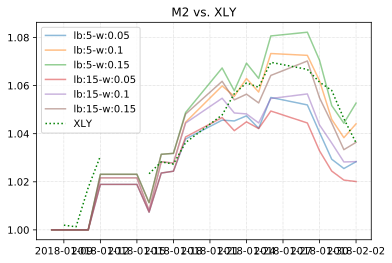

In [425]:
# Single lookback alpha
def plot_alpha_series(tsa, label1, xlabel, ylabel, title):
    plt.plot(tsa, alpha=0.3, label=label1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)

dwld_key = 'XLY'
log = False

def check_sector_vars(group, dwld_key, days):
    lb_range = [i for i in range(5, 25, 10)]
    w_range = [i/100 for i in range(5, 20, 5)]
    for l in lb_range:
        for w in w_range:
            _, _, _, pdf, benchmark = run_sector_opt(group, dwld_key, days, l, w)
            plt.plot(pdf, "-", alpha=0.5, label="lb:" + str(l) + "-w:" + str(w))
    plt.plot(benchmark, "g:", label=dwld_key)
    plt.legend(loc='best')
    plt.grid(axis='both', linestyle=':', linewidth=0.5)
    plt.title("M2 vs. " + dwld_key)
    plt.show()

check_sector_vars(spyf, dwld_key, days)

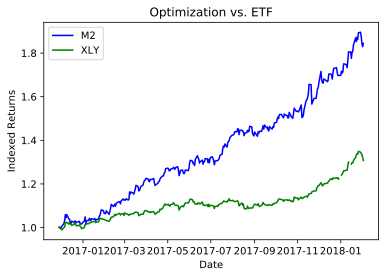

In [426]:
# Single sector long run
px_portion, returns, alloc, pdf, benchmark = run_sector_opt(spyf, dwld_key, hist_window, lb, we)
plot_two_series(pdf, benchmark, "M2", dwld_key, pdf.index.name, "Indexed Returns", "Optimization vs. ETF")
plt.show()

In [439]:
# Create Chart to show return spread vs. ETF for a given time window
# Conclusion: The shorter the holding gets the more likely to underperform
holding = 90; stop = int(len(alloc) - holding); jumps = 10
offsets = [x for x in range(0, stop, jumps)]
msg = "Portfolio metrics starting every {} trading days and holding for {} days"
print(msg.format(jumps, holding))
cols = ["M2", "Bechmark", "M2_Return", "M2_StdDev", "M2_Sharpe"]
results = pd.DataFrame([], index=offsets, columns=cols)
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')

dwld_key = 'XLY'
spyder_etf = px_spy_etfs[dwld_key].copy()

log = False
print('Working...')
for o in offsets:
    start = np.min([o, len(alloc)-1])
    end = np.min([o + holding, len(alloc)])
    p = px[start:end].copy()
    px_o, r, a, pdf = recommend_allocs(p, hist_window, lb, frequency, min_gross, max_gross, min_w, we)
    ret, std, sharpe = portfolio_metrics('M2', pdf);
    s_etf = spyder_etf[start:end]
    portfolio_metrics('ETF', pd.DataFrame(s_etf))
    results.loc[o, cols] = [compound(pdf)[-1:].values[0][0], compound(s_etf)[-1:].values[0], ret, std, sharpe]
print('Complete')

Portfolio metrics starting every 10 trading days and holding for 90 days
Working...
Complete


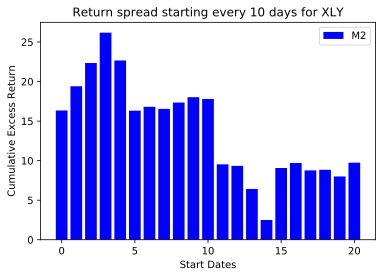

Portfolio underperformed: 0.0% of the time


In [440]:
def plot_spread_two_series(tsa, tsb, label1, label2, xlabel, ylabel, title):
    plt.bar(range(len(tsa)), (tsa - tsb)*100, label=label1, color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)

chart_title = "Return spread starting every {} days for {}".format(jumps, dwld_key)
rp = results[cols[0:2]].copy()
plot_spread_two_series(rp[cols[0]], rp[cols[1]], "M2", "Benchmark", "Start Dates", "Cumulative Excess Return", chart_title)
plt.show()

under = results[results["M2"] < results["Bechmark"]][results.columns[0]].count()
print("Portfolio underperformed: {0:.1f}% of the time".format(under/len(results)*100))

In [217]:
# show portfolio metrics for a given time window
log = True
msg = "Portfolio metrics for the last {} days"
print(msg.format(frame))
w = alloc[-frame:].astype(np.float)
r = returns[-frame:].astype(np.float)
port_perf = calc_port_performance(r.values, w.values)
pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
portfolio_metrics('M2', pdf);

Portfolio metrics for the last 252 days
M2 Return: 34.35%, StdDev: 10.06%, Sharpe: 3.41


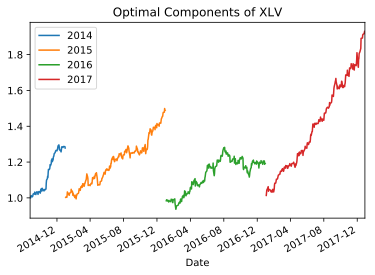

In [224]:
# plot portfolio performance by year
first_year = int(alloc.index[0].year)
last_year = int(alloc.index[-1].year)
years = [y for y in range(first_year, last_year, 1)] 

def perf_by_years(r, a, years):
    ax = plt.axes()
    for y in years:
        year = str(y)
        w = alloc.loc[year].astype(np.float16)
        r = returns.loc[year].astype(np.float16)
        p_perf = calc_port_performance(r.values, w.values)
        result = pd.DataFrame(p_perf, index=w.index, columns=[year])
        result.plot(title='Optimal Components of ' + dwld_key, ax=ax, legend='right')
        if log: print(year, result[-1:].values[0][0])

perf_by_years(returns, alloc, years)

In [276]:
alloc[-5:].astype(np.float16)

,ANDV,APA,APC,BHGE,CHK,COG,COP,CVX,CXO,DVN,...,OKE,OXY,PSX,PXD,RRC,SLB,VLO,WMB,XEC,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,0.0,0.0,0.150024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150024,0.0,0.0,0.144409,0.0,0.0,0.0,0.0,0.0,0.000000
2018-01-30,0.0,0.0,0.150024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150024,0.0,0.0,0.144409,0.0,0.0,0.0,0.0,0.0,0.000000
2018-01-31,0.0,0.0,0.150024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150024,0.0,0.0,0.144409,0.0,0.0,0.0,0.0,0.0,0.000000
2018-02-01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.082642
2018-02-02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.082642


In [271]:
# show top holdings and last recomended holding set
def selected_allocs(alloc, frame, freq, periods=99):
    w = alloc[-frame:].astype(np.float16)
    intervals = pd.to_datetime(date_intervals(w, freq).index.tolist())
    w = w.loc[intervals[-periods:]].sum(axis=0).sort_values(ascending=False)
    return w[w > 0]
# shows most frequent positions
top = 5
print("Number of Times for Top {} holdings during the last {} intervals".format(top, 99))
print((selected_allocs(alloc, frame, frequency, 99)[:top] / max_w).astype(np.int))
print("Number of Times for Top {} holdings during the last {} intervals".format(top, 5))
print((selected_allocs(alloc, frame, frequency, 5)[:top] / max_w).astype(np.int))
print("Number of Times for Top {} holdings during the last {} intervals".format(top, 1))
print((selected_allocs(alloc, frame, frequency, 1)[:top] / max_w).astype(np.int))

Number of Times for Top 5 holdings during the last 99 intervals
VLO     14
MPC     14
ANDV    12
PSX     11
OKE     10
dtype: int64
Number of Times for Top 5 holdings during the last 5 intervals
HP      2
SLB     2
BHGE    2
HAL     2
WMB     1
dtype: int64
Number of Times for Top 5 holdings during the last 1 intervals
XOM    0
dtype: int64


#### Sensitivities

In [410]:
def create_matrix(group, dwld_key, lbs, mws, frame):
    print("Creating Sensitivity Matrix...")
    df = pd.DataFrame([], index=lbs, columns=mws)
    df.index.name = "Lookback"
    df.columns.name = "Max Exposure"
    for i, l in enumerate(lbs):
        for j, w in enumerate(mws):
            #r, w = get_weights(px, frequency, lb=l, max_w=w)
            #port_perf = calc_port_performance(r.values, w.values)
            #pdf = pd.DataFrame(port_perf, index=r.index, columns=[dwld_key + "-cvxopt"])
            _, _, _, pdf, _ = run_sector_opt(group, dwld_key, frame, l, w)
            ret, std, sharpe = portfolio_metrics('M2', pdf);
            df.iloc[i, j] = (ret.astype(np.float16), std.astype(np.float16), sharpe.astype(np.float16))
    print("Complete")
    return df
def heatmap(df, ctitle, cmap=plt.cm.gray):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    ax.set_title(ctitle)
    plt.colorbar(axim)

In [422]:
lbs = [x for x in range(5, 30, 5)]
mws = [y/100 for y in [x for x in range(5, 30, 5)]]
log = False
sm = create_matrix(spyf, 'XLY', lbs, mws, days)

Creating Sensitivity Matrix...
Complete


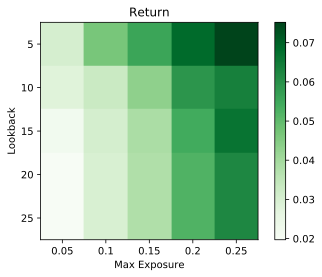

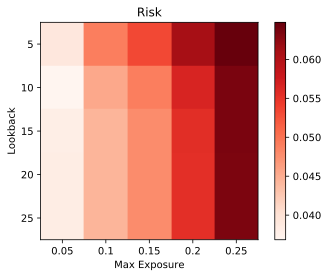

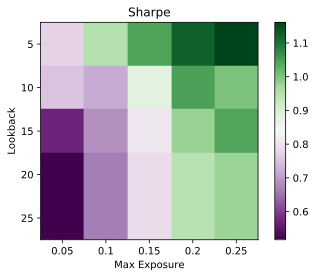

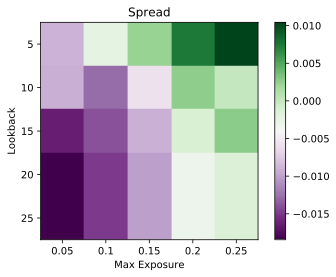

In [423]:
m_list = ["Return", "StdDev", "Sharpe"]
extract = lambda x: x[curr]
spread = lambda x: x[0] - x[1]
curr = 0; df = sm.applymap(extract); heatmap(df.astype(float), "Return", cmap=plt.cm.Greens)
curr = 1; df = sm.applymap(extract); heatmap(df.astype(float), "Risk", cmap=plt.cm.Reds)
curr = 2; df = sm.applymap(extract); heatmap(df.astype(float), "Sharpe", cmap=plt.cm.PRGn)
df = sm.applymap(spread); heatmap(df.astype(float), "Spread", cmap=plt.cm.PRGn)

In [ ]:
sm

#### Old Cells

Loaded pricing for XLRE-hold-pricing.csv, with shape (870, 33)
Loaded pricing for spy-sectors.csv, with shape (870, 10)
M2 Return: 40.46%, StdDev: 14.11%, Sharpe: 2.87
XLRE Return: 22.15%, StdDev: 26.95%, Sharpe: 0.82


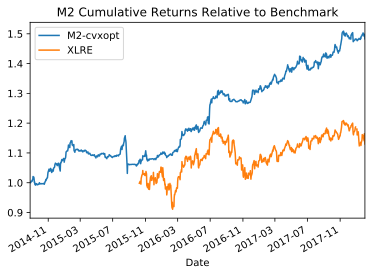

In [16]:
#Produce optimization for a given sector group
dwld_key = 'XLRE'
px = load_pricing(dwld_key + '-hold-pricing.csv', 'Date')
px_spy_etfs = load_pricing('spy-sectors.csv', 'Date')
spyder_etf = px_spy_etfs[dwld_key].copy()

# Run a sector specific optimization
px_portion, returns, alloc, pdf = recommend_allocs(px, hist_window, lookback, frequency, max_w=0.1)
portfolio_metrics('M2', pdf);
s_etf = (spyder_etf[-len(px_portion):].pct_change() + 1).cumprod()
portfolio_metrics(dwld_key, pd.DataFrame(s_etf));

# Plot optimization
ax = pdf.plot(title="M2 Cumulative Returns Relative to Benchmark");
s_etf.plot(ax=ax, legend='right');

In [ ]:
for x in ['arkq', 'arkw', 'arkg', 'arkk']:
    df = clean_load(r'holdings-ark-', 'ticker', ['ticker','company', 'weight(%)'], col_names, x, 0)
    df = clean_idx(df, ' ')
    print(df.tail())

In [ ]:
df = clean_load(r'holdings-ark-', 'ticker', ['ticker','company', 'weight(%)'], col_names, 'arkk', 0)
df = clean_idx(df, ' ')
df

In [217]:
np.random.seed(42)
vals = np.random.random(25).reshape(5,5)
idx = [x for x in range(1, 6, 1)]
df = pd.DataFrame(vals, index=idx, columns=idx)
df = df * 10; df.loc[1:3, 3] = 0.1
df.applymap(cleanmin)

,1,2,3,4,5
1,3.745401,9.507143,1.000000,5.986585,1.560186
2,1.559945,1.000000,1.000000,6.011150,7.080726
3,1.000000,9.699099,1.000000,2.123391,1.818250
4,1.834045,3.042422,5.247564,4.319450,2.912291
5,6.118529,1.394939,2.921446,3.663618,4.560700


In [ ]:
# Old load spy sector components

sectors = ticker_map['spy_sectors']
sector_tickers_map = {}
companies = pd.DataFrame([])

colstoload = ['Symbol','Company Name', 'Index Weight']
pattern = r'holdings-spy-'

#def load_components(pattern, cols, skiprows=1, sectors, ):
    
flist = os.listdir(component_path)
files = [f for f in flist if f.startswith(pattern)]
for s in sectors:
    fname = component_path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=1, index_col='Symbol', usecols=colstoload)
    df['ETF'] = s
    sector_tickers_map[s] = df.index.tolist()
    companies = companies.append(df)
if log: print("Company Sample:", companies.shape); 

px_etfs = load_pricing('sectors-spy.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

# load ark etfs components

In [ ]:
df = pd.DataFrame(np.random.random(15).reshape(5,3), index=[1,2,np.nan," ", "asd asd"], columns=['A','B','C'])
df.index.name = 'Symbol'
df.loc[' '] = " "; df.loc['asd asd'] = " "
df.loc[2,'B'] = np.nan
df
clean_idx(df, ' ')

In [ ]:
retail = load_pricing('XLY' + '-hold-pricing.csv', 'Date')
retail = clean_nas(retail)
l = 300
amzn = retail['AMZN'].tail(l)
portfolio_metrics('AMZN', pd.DataFrame(amzn));
amzn.pct_change().mean() * l, amzn.pct_change().std() * sqrt(l)
amzn[-1:].values / amzn[:1].values

In [303]:
px = load_pricing('ARKK' + '-hold-pricing.csv', 'Date')
px = clean_nas(px)
px.describe().T.sort_values('min').head(15)

Loaded pricing for ARKK-hold-pricing.csv, with shape (870, 55)


,count,mean,std,min,25%,50%,75%,max
MGTI,870.0,1.532535,0.960380,1.00,1.0000,1.000,1.717500,7.100000
BCG,870.0,6663.560407,5891.692855,1.00,1.0000,5985.000,7235.555054,21851.900391
GBTC,870.0,3.064629,5.048063,1.00,1.0000,1.000,1.383324,38.054947
ONVO,870.0,3.525310,1.562290,1.34,2.4800,3.080,4.175000,7.960000
CERS,870.0,4.688195,1.204305,2.02,4.0300,4.690,5.607500,7.390000
CGEN,870.0,5.795115,1.733529,2.35,4.4000,6.150,6.970000,9.710000
PACB,870.0,6.336701,2.323733,2.52,4.7025,5.830,8.127500,13.450000
HDP,870.0,14.847213,6.830295,3.25,9.6925,12.925,20.799999,29.200001
LC,870.0,10.686368,6.771614,3.51,5.4425,6.450,14.825000,27.900000
VCYT,870.0,7.653247,1.670535,4.51,6.4800,7.710,8.487500,12.870000


In [ ]:
px = load_pricing('test-XLRE' + '-hold-pricing.csv', 'Date')
clean = clean_nas(px)
cols = clean.columns[:10]
clean[cols]

In [ ]:
vals = np.arange(9).reshape(3, 3)
vals
m2 = np.array([vals[0], vals[1], vals[2]])
m2
matrix = pd.DataFrame(m2, index=['1','2','3'], columns=['A','B','C'])
#matrix[matrix.columns] = vals
matrix
[dwld_key] * 10

In [ ]:
# Downloads pricing from yahoo for components + sector ETF
tickers = sector_tickers_map[dwld_key] # for individual components
#tickers = ticker_map["sectors"] # for individual ETFs
px = get_pricing(dwld_key + '-hold-pricing.csv', tickers, start_date.strftime(date_fmt))
etf = get_pricing(dwld_key + '.csv', dwld_key, start_date.strftime(date_fmt))
spyder_etf = pd.DataFrame(etf)
spyder_etf.index.name = "Date"
spyder_etf.columns=[dwld_key]
spyder_etf.to_csv(dwld_key + '.csv')

In [ ]:
#CHECK compounding math
#what were the top 10 allocations tickers?
top_stocks = alloc.sum(axis=0).sort_values(ascending=False)[:10].index.tolist()
# what was their allocation?
alloc = alloc[top_stocks]
# how much did we allocate to them?
cum_alloc = alloc.sum(axis=1)
# multiply the daily returns of top allocations times our allocation
port_return = (returns[top_stocks] * alloc).sum(axis=1)
# we add 1 to get the compounding index
port_index = (port_return + 1).cumprod()
#cumulative return for the portfolio
print(port_index[-1:], len(port_index), "days")

port_perf = calc_port_performance(returns[top_stocks].values, alloc.values)
print(port_perf[-1:], len(port_perf), "days")
print("annual return", pd.Series(port_perf).pct_change().mean() * 252)

In [ ]:
# show behaviour during sepcific time window
start = '1-1-2017'; days = 15
end = datetime.strptime(start, date_fmt) + timedelta(days)
window = pdf.loc['2017-1-31':'2017-9-30']
portfolio_metrics(window)

In [ ]:
for s in sector_tickers_map.keys():
    print(len(sector_tickers_map[s]))
    
#test both the portfolio performance using date intervals with optimization
df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_allocations = pd.DataFrame(np.zeros((len(intervals),cols)), index=pd.to_datetime(intervals))

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(mean_returns, cov_matrix)
    hist_allocations.loc[i.date()] = weights

port_perf = calc_port_performance(df.loc[intervals].values, hist_allocations.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

#### Test Methods

In [ ]:
d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))

df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
(df+1).cumprod().mean(axis=1).plot()

In [ ]:
#test both the portfolio performance using date intervals without optimization / equal weights
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    #lb_returns = df.loc[:i.date()].tail(lookback)
    weights = np.array([1/cols for _ in range(cols)])
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')

port_perf = calc_port_performance(df.values, hist_alloc.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
#test both the portfolio performance using date intervals with optimization
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(n, mean_returns, cov_matrix, min_w=0.0, max_w=0.3)
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
hist_alloc

port_perf = calc_port_performance(df.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf)
pdf.plot()
port_perf[-1:]

In [ ]:
px = get_pricing(ticker_map[key], '01/01/2017')
returns = px.sort_index().pct_change()
compound(returns).plot()

In [ ]:
w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(returns)

ann_returns = np.dot((mean_returns * 252), weights)
ann_stdev = np.sqrt(252/len(returns)) * std_dev
print(weights.shape, cov_matrix.shape)
port_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
print("eq weight return(exp)", ann_returns)
print("port risk(exp):", port_variance)
print("sharpe ratio:", ann_returns / port_variance)

In [ ]:
# Long only portfolio optimization.
weights = get_mvo_allocations(mean_returns, cov_matrix)
np_weights = np.array([weights]).T
exp_return = np.dot(np.array([mean_daily_returns.values]), np_weights) * 252
portfolio_std_dev = np.sqrt(np.dot(np_weights.T, np.dot(cov_matrix, np_weights))) * np.sqrt(252)
print("optimized return(exp):", exp_return)
print("optimized portfolio risk(exp):", portfolio_std_dev)
print("sharpe ratio:", exp_return / portfolio_std_dev)

In [ ]:
# Compute trade-off curve.
SAMPLES = 100
weights = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    weights.append([i[0] for i in w.value.tolist()])
    risk_data[i] = cvx.sqrt(risk).value
    ret_data[i] = ret.value
print('Optimization status:', prob.status)
#w.value, risk_data, ret_data
#ret_data / risk_data # sharpe ratio
#risk_data[np.argmin(risk_data)], risk_data[np.argmax(ret_data)]
#wgt_cum_ret = (ret_data + 1).cumprod()
cols = returns.columns.tolist();
allocs = show_weights(weights, returns.columns, ret_data, risk_data); allocs.tail()
allocs[cols].plot()
print(allocs[-1:].apply(two_dec))

In [ ]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = range(1, 100, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker], ret_data[marker]))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    ax.annotate(returns.columns[i], xy=(sqrt(Sigma[i,i]).value, mu[i]))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
gamma_vals.shape, risk_data.shape, ret_data.shape
summary = pd.DataFrame([], columns=['gamma', 'risk', 'return'], index=range(SAMPLES))
summary['gamma'] = np.array([gamma_vals]).T
summary['risk'] = np.array([risk_data]).T
summary['return'] = np.array([ret_data]).T
summary[['risk','return']].plot(kind='line')

In [ ]:
numdays, cols = 252, 10

np.random.seed(42)
numdays, cols = 100, 10
end_date_str, tgt_date_str = '12-31-2017', '12-27-2017'
freq = 7; lookback = 20

arr = (np.random.rand(numdays, cols) - 0.5) / 10
weights = np.random.rand(1, cols)
weights = weights / np.sum(weights, axis=1).T

In [ ]:
#test the portfolio performance calculation
port_perf = calc_port_performance(arr, weights)
#pd.DataFrame(port_perf).plot()
port_perf

In [ ]:
#test the date rules / intervals
end_date = datetime.strptime(end_date_str, date_fmt)
d_rng = sorted([end_date - timedelta(x) for x in range(0, numdays)]) # using list comprenhensions
sorted(date_rules(d_rng, tgt_date_str, freq))

d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))
intervals = list(sorted(date_rules(d_rng, tgt_date_str, freq)))
print("check:", len(intervals), "equals", numdays // freq, "result:",len(intervals) == numdays // freq) # check if intervals works
intervals[-5:]